<a href="https://colab.research.google.com/github/coolcat218/Medical-Diagnosis/blob/main/Medical_Diagnosis_FAERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning/Preparing FAERS Q1 2025 Data
Convert FAERS Q1 2025 data into a pandas DataFrame.

In [4]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('FAERS_Q125_Data.csv')

# Clean data:
# Replace missing values with "NA"
df.fillna("NA", inplace=True)

# Ensure Report ID are all unique by removing duplicate rows based on 'Report ID'
df.drop_duplicates(subset=['Report ID'], inplace=True)

display(df.head())

/tmp/ipython-input-2423150567.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("NA", inplace=True)


,Report ID,Drugs,Country,Seriousness (Death),Seriousness (Hospitalization),Reactions
0,4717055,ETOPOSIDE; ETOPOSIDE; IFOSFAMIDE; IFOSFAMIDE; ...,CN,0.0,1.0,Hepatic failure; Neutropenia; Thrombocytopenia
1,4789549,ACETAMINOPHEN; IBUPROFEN; ISOPROPYL ALCOHOL; B...,US,1.0,1.0,Suspected suicide; Exposure during pregnancy
2,4795581,CIMZIA,US,0.0,0.0,Psoriatic arthropathy
3,4795580,SYMBICORT; SYMBICORT; SYMBICORT; SYMBICORT,US,0.0,0.0,Asthma
4,4795583,DUPIXENT,US,0.0,0.0,Nasal polyps; Condition aggravated; Inappropri...


1) Filtering for most frequently reported drugs and reactions taken in the FAERS dataset

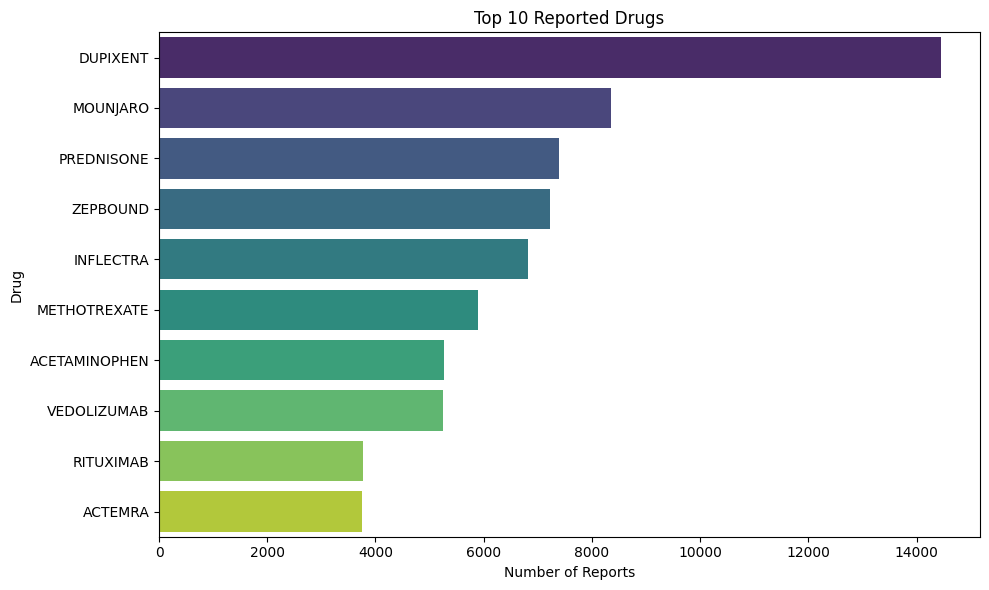

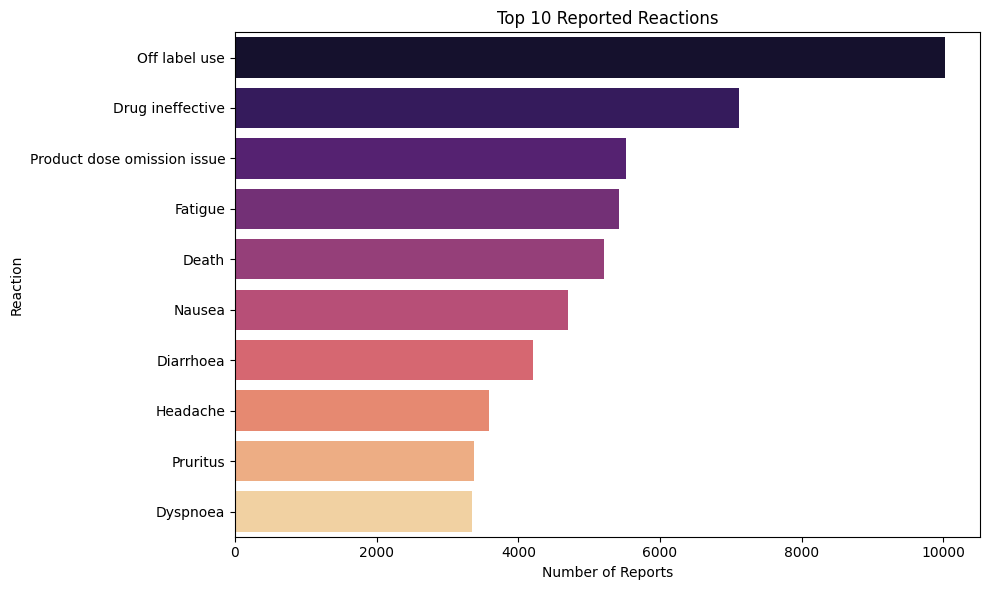

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import chain

# Most common drugs
drug_counts = Counter(chain.from_iterable(
    d.split("; ") for d in df["Drugs"].dropna()
))
top_drugs = pd.DataFrame(drug_counts.most_common(10), columns=["Drug", "Count"])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_drugs, x="Count", y="Drug", palette="viridis", hue="Drug", legend=False)
plt.title("Top 10 Reported Drugs")
plt.xlabel("Number of Reports")
plt.ylabel("Drug")
plt.tight_layout()
plt.show()

# Most common reactions
reaction_counts = Counter(chain.from_iterable(
    r.split("; ") for r in df["Reactions"].dropna()
))
top_reactions = pd.DataFrame(reaction_counts.most_common(10), columns=["Reaction", "Count"])

plt.figure(figsize=(10, 6))
sns.barplot(data=top_reactions, x="Count", y="Reaction", palette="magma", hue="Reaction", legend=False)
plt.title("Top 10 Reported Reactions")
plt.xlabel("Number of Reports")
plt.ylabel("Reaction")
plt.tight_layout()
plt.show()

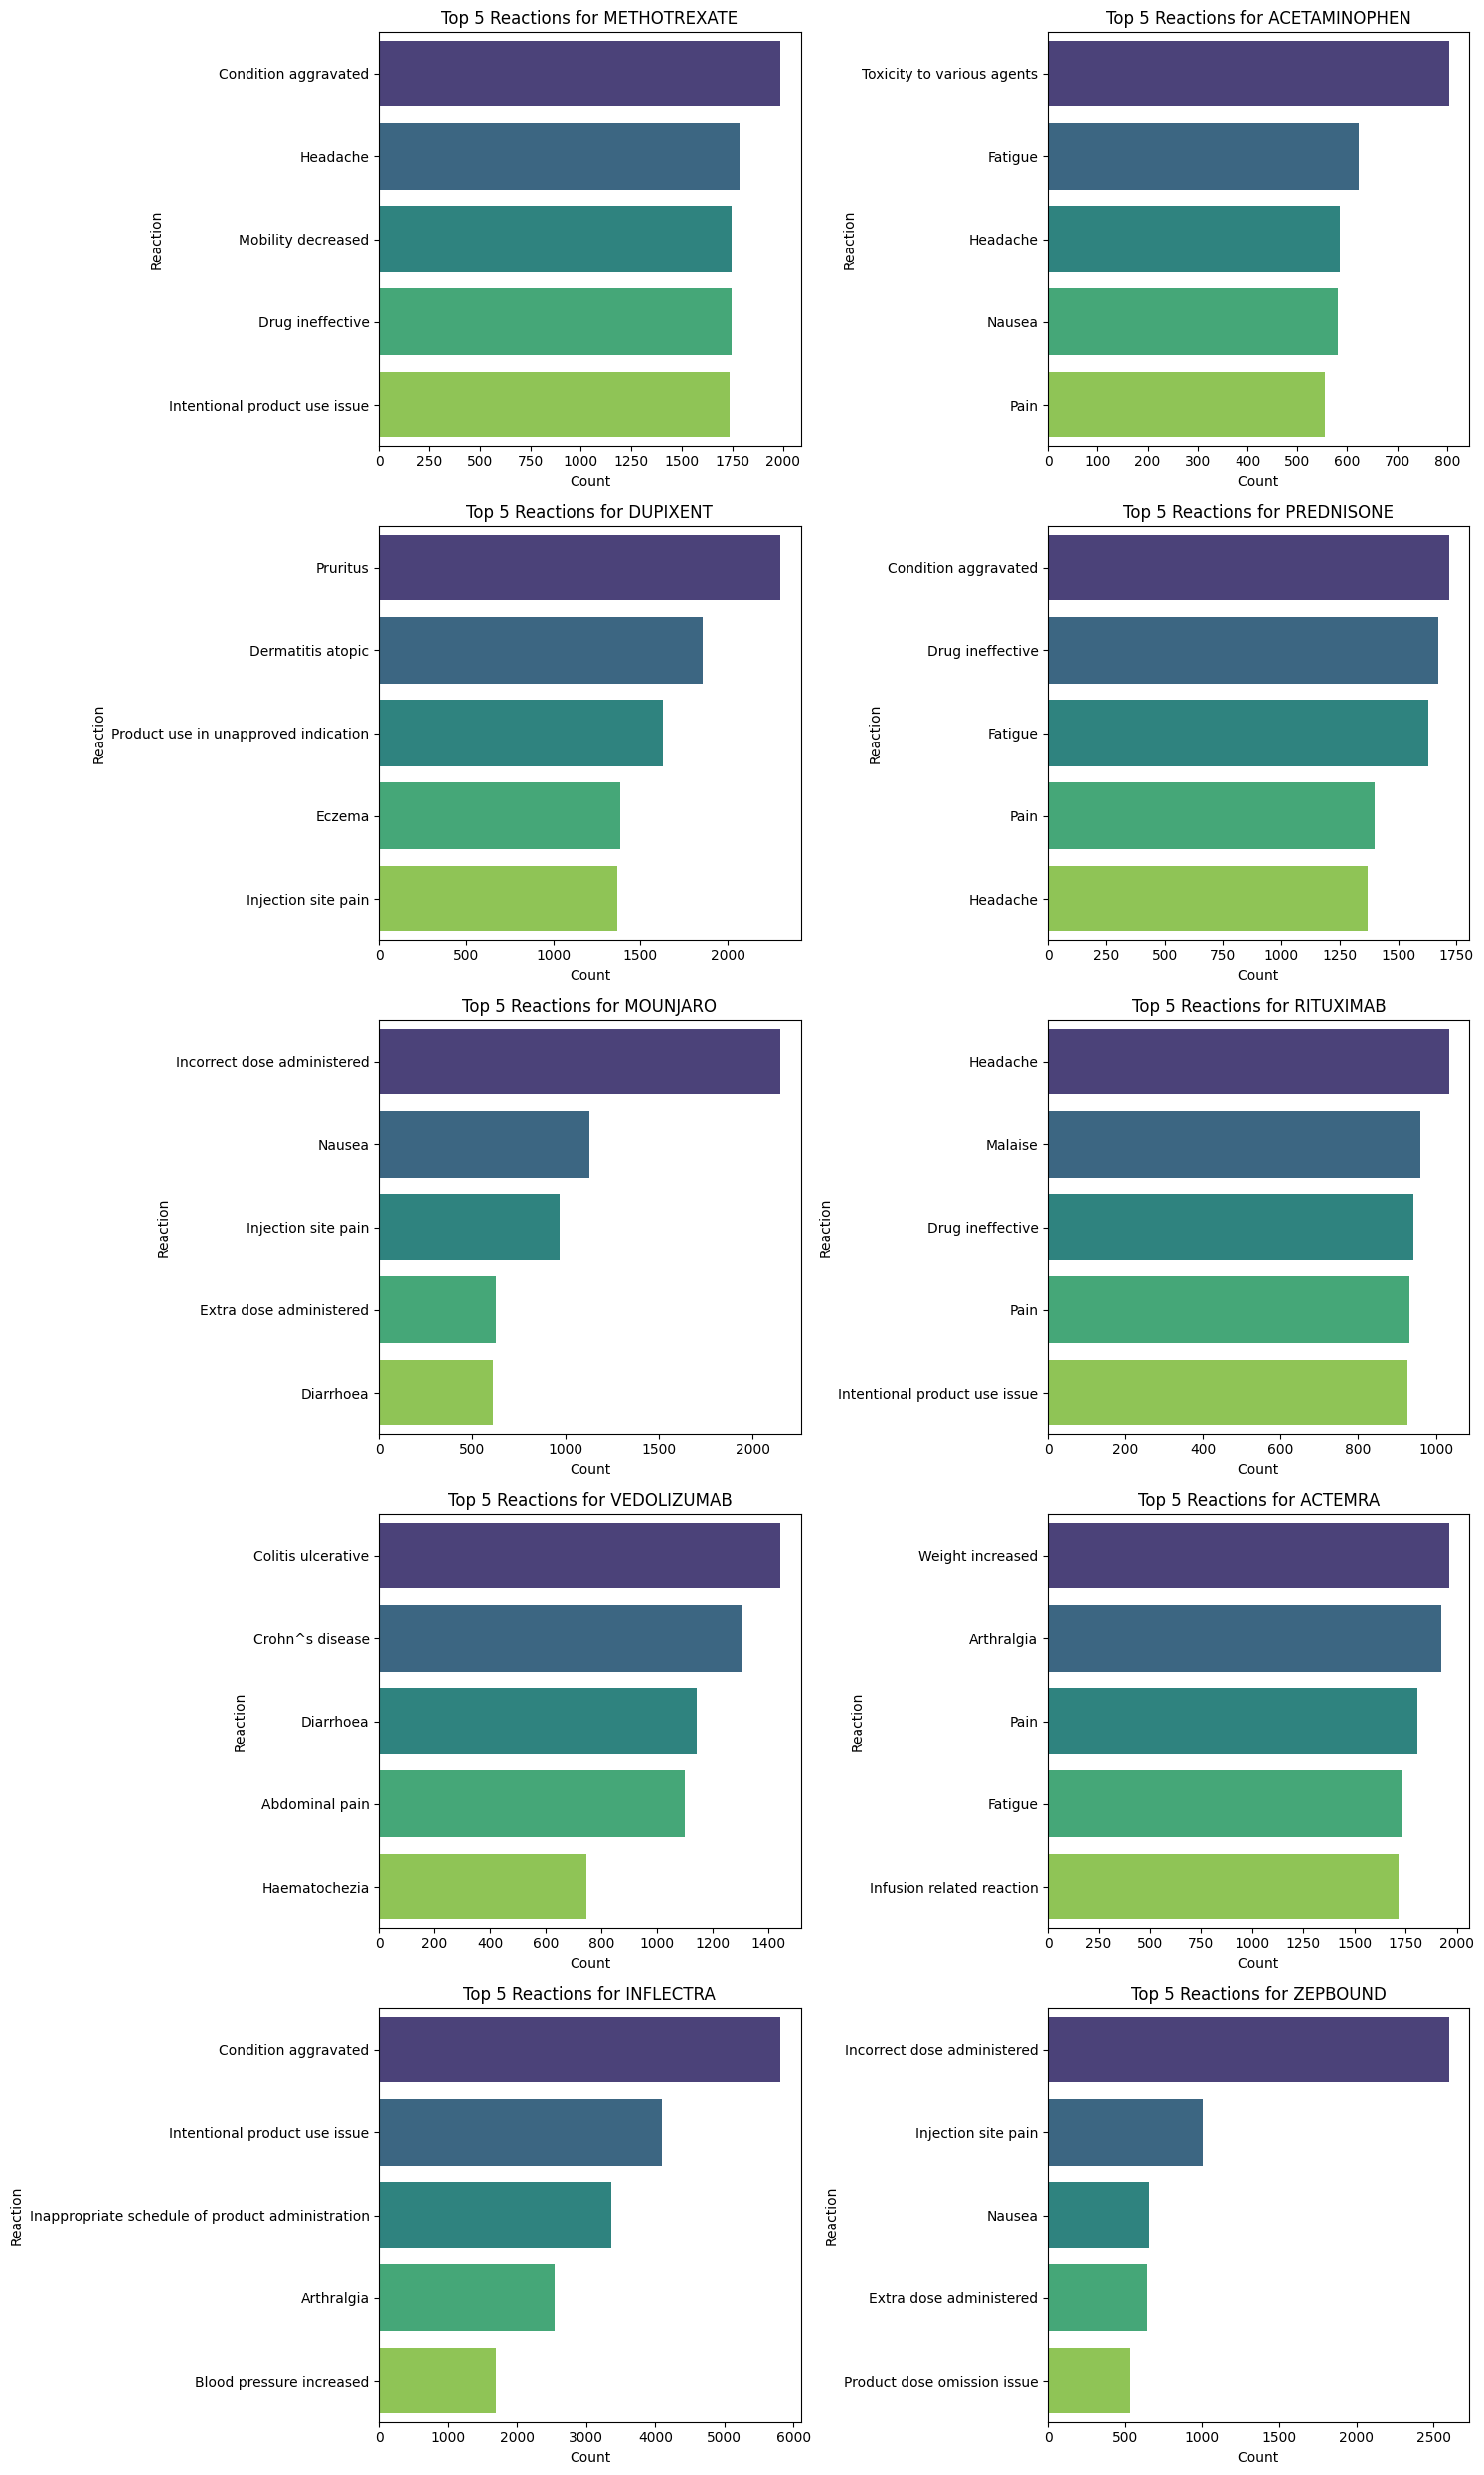

In [20]:
# Get the list of top 10 drugs from the 'top_drugs' DataFrame
top_10_drug_names = top_drugs['Drug'].tolist()

# Filter drug_reaction_df to include only the top 10 drugs
top_10_drug_reaction_df = drug_reaction_df[drug_reaction_df['Drug'].isin(top_10_drug_names)].copy()

# Initialize a dictionary to store the top 5 reactions for each of the top 10 drugs
top_reactions_per_drug = {}

# Iterate through each drug in the filtered DataFrame
for index, row in top_10_drug_reaction_df.iterrows():
    drug_name = row['Drug']
    # Exclude the 'Drug' column and 'Off label use' reaction, then get reaction counts
    reaction_counts = row.drop(['Drug', 'Off label use'], errors='ignore')
    # Sort reactions by count in descending order and get the top 5
    top_5_reactions = reaction_counts.sort_values(ascending=False).head(5)
    # Store the top 5 reactions in the dictionary
    top_reactions_per_drug[drug_name] = top_5_reactions.to_dict()

# Define plots
n_drugs = len(top_reactions_per_drug)
n_cols = 2
n_rows = (n_drugs + n_cols - 1) // n_cols # Calculate required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, (drug, reactions) in enumerate(top_reactions_per_drug.items()):
    # Create a DataFrame for the current drug's top reactions
    drug_plot_df = pd.DataFrame(list(reactions.items()), columns=['Reaction', 'Count'])

    # Create the bar plot
    sns.barplot(ax=axes[i], data=drug_plot_df, x="Count", y="Reaction", palette="viridis", hue='Reaction', legend=False)
    axes[i].set_title(f"Top 5 Reactions for {drug}")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel("Reaction")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 2) aggregate / count symptoms per drug to show frequency of reported symptoms while on a given drug

In [15]:
# iterates through each of the drugs and creates columns that counts number of instances for each type of reaction

import pandas as pd
from collections import Counter

# Load the dataframe
df = pd.read_csv("FAERS_Q125_Data.csv")

# Initialize an empty dictionary to store drug-reaction counts
drug_reaction_counts = {}

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    drugs = [d.strip() for d in row['Drugs'].split(';') if d.strip()]
    reactions = [r.strip() for r in row['Reactions'].split(';') if r.strip()]

    # For each drug in the row, iterate through the reactions
    for drug in drugs:
        if drug not in drug_reaction_counts:
            drug_reaction_counts[drug] = Counter()

        # Increment the count for each reaction for the current drug
        for reaction in reactions:
            drug_reaction_counts[drug][reaction] += 1

# Convert the nested dictionary to a pandas DataFrame
# Use from_dict and orient='index' to have drugs as index and reactions as columns
drug_reaction_df = pd.DataFrame.from_dict(drug_reaction_counts, orient='index')

# Fill NaN values with 0 (for reactions that didn't occur for a specific drug)
drug_reaction_df = drug_reaction_df.fillna(0).astype(int)

# Reset index to make 'Drug' a column
drug_reaction_df.reset_index(inplace=True)
drug_reaction_df.rename(columns={'index': 'Drug'}, inplace=True)

# Calculate the sum of reaction counts for each drug (excluding the Drug column)
drug_reaction_df['Total_Reactions'] = drug_reaction_df.drop(columns=['Drug']).sum(axis=1)

# Only filter for nontrivial occurrences of symptoms i.e. >200 instances
drug_reaction_df = drug_reaction_df[drug_reaction_df['Total_Reactions'] >= 200]
drug_reaction_df = drug_reaction_df.drop(columns=['Total_Reactions'])

# Print the resulting DataFrame head to verify
print(drug_reaction_df.head())

            Drug  Hepatic failure  Neutropenia  Thrombocytopenia  \
0      ETOPOSIDE                5           32                26   
1     IFOSFAMIDE                2           13                15   
2    GEMCITABINE                4           19                38   
4  DEXAMETHASONE                8          298               276   
6      CISPLATIN                6           41                28   

   Cytomegalovirus infection reactivation  Agranulocytosis  \
0                                       3                8   
1                                       0                1   
2                                       0                1   
4                                      17               10   
6                                       0                3   

   Drug-genetic interaction  Toxicity to various agents  Haematotoxicity  \
0                         1                           7                5   
1                         0                           1           

In [21]:
# Save the filtered DataFrame to a new CSV file
drug_reaction_df.to_csv("FAERS_Q125_Symptom_Sum.csv", index=False)

# Provide a download link for the CSV file
from google.colab import files
files.download("FAERS_Q125_Symptom_Sum.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>